# Vizualization of results

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# sns.set(rc={"figure.figsize": (20, 20)})

In [4]:
colors = colors = sns.color_palette("Paired")

In [5]:
for i in range(0, len(colors), 2):
    r,g,b = colors[i]
    pivot = max(r,g,b)
    if r == pivot:
        colors[i] = (r, min(g*1.2, 1), min(b*1.25, 1))
    elif g == pivot:
        colors[i] = (min(r*1.2, 1), g, min(b*1.4, 1))
    else:
        colors[i] = (min(r*1.25, 1), min(g*1.1, 1), b)

In [14]:
def bar_transparent(x,y,col,data,ci='sd'):
    sns.set(font_scale=2)
    sns.set_style("whitegrid")
    col_wrap = None if col==None else 5
    
    hue_categories = ['lr_en not significant','lr_en', 'svc_lin not significant', 'svc_lin', 'svc_rbf not significant', 'svc_rbf']
    hue_categories_colors = colors

    data = data.reset_index()
    hue_column = "statistical significance "
    data[hue_column] = data.apply(lambda row: row[x] if row["p-value"] < 0.05 else row[x]+" not significant", axis=1)
    
    palette = dict(zip(hue_categories, hue_categories_colors))
    ax = sns.catplot(
        x=x,
        y=y,
        col=col,
        col_order=['ICA_15', 'ICA_4', 'PCA_15', 'PCA_4', 'ERP'],
        hue=hue_column,
        ci=ci,
        data=data, 
        kind='bar', 
        capsize=.05,
        errwidth = 1,
        legend=False,
        col_wrap=col_wrap,
        dodge=False,
        palette=palette,
        margin_titles=True,
        sharex=True, 
        sharey=True,
        height=5, 
        aspect=1,
    ).set_titles("Pipeline: {col_name}").set_axis_labels("", "Internal accuracy").set_xticklabels(["SVC-rbf", "SVC-lin", "LR-en"])
    
    ax.savefig("rumination_classification_summary.png")

    return ax

In [ ]:
file_name_ICA = "../../data/results_classification/classification_ICA_vizualization_error.pkl"
results_ICA = pd.read_pickle(file_name_ICA)

file_name_PCA = "../../data/results_classification/classification_PCA_vizualization_error.pkl"
results_PCA = pd.read_pickle(file_name_PCA)

file_name_ERP = "../../data/results_classification/classification_ERP_vizualization_error.pkl"
results_ERP = pd.read_pickle(file_name_ERP)

In [ ]:
results_df = pd.concat([results_ICA, results_PCA, results_ERP], ignore_index=True)

In [8]:
file_name = "../../data/results_classification/classification_results_without_functions_visualization_error.pkl"
results_df = pd.read_pickle(file_name)

In [9]:
results_df['pipeline_name'] = results_df['pipeline_name'].apply(lambda x: x[:-5])

For plotting error bars - ugly hack

In [10]:
duplicates=10000

#duplicate observations to get good std bars
dfCopy = results_df.loc[results_df.index.repeat(duplicates)].copy()
dfCopy['mean_cv_balanced_accuracy'] = np.random.normal(dfCopy['mean_cv_balanced_accuracy'].values,dfCopy['std_cv_balanced_accuracy'].values)
dfCopy['mean_cv_precision'] = np.random.normal(dfCopy['mean_cv_precision'].values,dfCopy['std_cv_precision'].values)

### Pipelines and Models

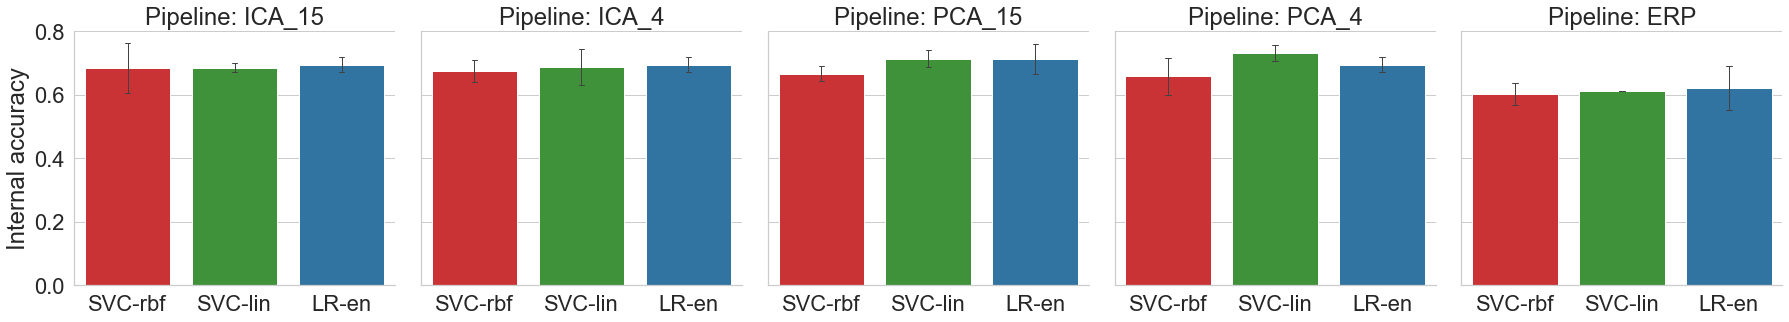

In [15]:
bar_transparent(x="model", y="mean_cv_balanced_accuracy", col="pipeline_name", ci='sd', data=dfCopy)

In [ ]:
results_df

In [ ]:
mean_train_precision_list = []
for index, row in results_df.iterrows():
    cv_results_params = row.cv_results['params']
    params = row.parameters
        
    index = cv_results_params.index(params)
    mean_train_precision = row.cv_results['mean_train_precision'][index]
    mean_train_precision_list.append(mean_train_precision)

    print(mean_train_precision)
mean_train_precision_list = np.array(mean_train_precision_list)
mean_train_precision_df = pd.DataFrame(mean_train_precision_list)
results_df['mean_train_precision'] = mean_train_precision_df

In [ ]:
results_df.head()

In [ ]:
# summarize_df = results_df[results_df['p-value'] <= 0.05]
summarize_df = results_df
summarize_df = summarize_df[["data_set", "mean_cv_balanced_accuracy", "mean_train_balanced_accuracy", "mean_cv_precision", "mean_train_precision", "pipeline_name", "model", "std_cv_balanced_accuracy", "std_cv_precision", "p-value", 'parameters', 'external_test_accuracy']]
summarize_df = summarize_df.reset_index()
columns_order = ["data_set", "pipeline_name",  "model", "mean_train_balanced_accuracy", "mean_cv_balanced_accuracy", "std_cv_balanced_accuracy", "mean_train_precision", "mean_cv_precision", "std_cv_precision", "p-value", 'external_test_accuracy', "parameters"]
summarize_df = summarize_df[columns_order].rename(columns = {'mean_train_balanced_accuracy': 'mean train accuracy', 'mean_cv_balanced_accuracy': 'mean test accuracy', "std_cv_balanced_accuracy": "accuracy std", "mean_train_precision" : "mean train precision", "mean_cv_precision": "mean test precision",  "std_cv_precision": "precision std", 'external_test_accuracy' : 'External validation accuracy'}, inplace = False)

summarize_df['# spatial filter components'] = summarize_df['parameters'].apply(lambda x: x['ica__n_components'] if x.get('ica__n_components') is not None else (x['spatial_filter__n_components'] if x.get('spatial_filter__n_components') is not None else '-' ))
summarize_df['# selected features'] = summarize_df['parameters'].apply(lambda x: x['feature_selection__n_components'])
summarize_df = summarize_df.drop(columns=['parameters'])

In [ ]:
with pd.option_context("display.max_colwidth", -1):
    display(summarize_df)

In [ ]:
summarize_df["p-value"] = pd.to_numeric(summarize_df["p-value"])
summarize_df = summarize_df.round({'mean train accuracy': 3, 'mean test accuracy': 3, 'accuracy std': 3, 'mean train precision': 3, 'mean test precision': 3, 'precision std': 3, 'p-value': 3, 'External validation accuracy' : 3,})

In [ ]:
summarize_df

In [ ]:
summarize_df.to_csv(
    "classification_summary.csv"
)

--------------

Permutation tests results

In [ ]:
permutation_scores = results_df['permutation_score'].to_numpy()
scores = results_df['mean_cv_balanced_accuracy'].to_numpy()

In [ ]:
# 2 7 8 10 11 14
test = permutation_scores[10]
test_score = scores[10]

In [ ]:
# sns.set(rc={"figure.figsize": (40, 20)})
sns.set_style("whitegrid")
ax = sns.displot(test, bins=20, height=8.27, aspect=11.7/8.27)
ax.set(xlabel='Accuracy score', ylabel='Count')

score_label = (f"Score on original\ndata: {test_score:.3f}")

plt.text(0.649, 122, score_label, fontsize=12, bbox=dict(facecolor='blue', alpha=0.1, edgecolor='black', linewidth=2))
plt.axvline(test_score, ls='--', color='r')

ax.savefig("probalility_distribution_PCA_15_svc_lin.png")